The primary analysis focused on identifying factors associated with the binary outcome of whether a child's vaccination with other variables. Logistic regression analysis was employed to model the relationship between various parental concerns and access barriers (independent variables) and this vaccination outcome (dependent variable).

Prior to conducting the logistic regression, the dataset was pre-processed to handle missing values. Numerical variables were imputed with the mean, and categorical variables with the mode. To address potential issues of perfect separation or quasi-separation, which can lead to unstable model estimates, a thorough examination of the relationship between each predictor variable and the outcome variable was conducted using cross-tabulations and frequency counts. Predictor variables exhibiting perfect or near-perfect prediction of the outcome were excluded from the logistic regression model to ensure model stability and interpretability.

The final logistic regression model's coefficients, standard errors, p-values, and odds ratios were examined to determine the strength and direction of the associations between the independent variables and the likelihood of other variables. Model performance was assessed using metrics such as the classification report, confusion matrix, and Receiver Operating Characteristic (ROC) curve with the Area Under the Curve (AUC). Statistical analyses were performed using the pandas, numpy, and statsmodels libraries in Python.

In [1]:
# CODE 1 FOR THE ARTICLE
############################################
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor columns
predictor_columns_initial = df.columns[0:31]

# Target columns (Q01 to Q25)
target_columns = [f'Q{i:02d}' for i in range(1, 26)]

# List to store model results
model_results = []

# Analyze each target column
for target_column in target_columns:
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found.")
        continue

    y = pd.to_numeric(df[target_column].copy(), errors='coerce')
    X_initial = df[predictor_columns_initial].copy()

    # --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
    problematic_predictors = []
    print(f"\n--- Checking for Potential Separation (Value Counts) for target: {target_column} ---")
    for col in X_initial.columns:
        print(f"\nValue counts for predictor '{col}':")
        print(X_initial[col].value_counts(dropna=False))
        print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
        for val in X_initial[col].unique():
            subset_y = y[X_initial[col] == val]
            print(f"  Value '{val}':")
            print(subset_y.value_counts(dropna=False))
            if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
                if col not in problematic_predictors:
                    problematic_predictors.append(col)
                    print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

    print("\nPotentially problematic predictors:", problematic_predictors)

    # Update predictor columns by removing the problematic ones
    predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
    X = X_initial[predictor_columns_final].copy()

    # Handle missing values
    for col in X.select_dtypes(include=np.number).columns:
        X.loc[:, col] = X[col].fillna(X[col].mean())
    for col in X.select_dtypes(include='object').columns:
        try:
            X.loc[:, col] = X[col].fillna(X[col].mode()[0])
            X.loc[:, col] = X[col].astype('category')
        except IndexError:
            print(f"Warning: Cannot impute missing for categorical column '{col}'.")
    if y.isnull().any():
        print("Warning: Missing values in target. Imputing with mode.")
        try:
            y = y.fillna(y.mode()[0])
            y = pd.to_numeric(y)
        except IndexError:
            print("Error: Cannot impute missing in target (no mode).")
            continue

    # Convert 'Sex' to category before splitting
    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Check for all NaN columns
    nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
    predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
    X_train = X_train[predictor_columns_final_train]
    X_test = X_test[predictor_columns_final_train]

    # Align the indices of X_train and y_train
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]

    # Build and fit the model
    if predictor_columns_final_train:
        formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" if 'Q' in col else f"C({col})" if col in ['Sex', 'Age'] else f"'{col}'" for col in predictor_columns_final_train])
        try:
            model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
            result = model.fit()

            # Calculate AUC
            y_pred_proba = result.predict(X_test)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Create DataFrame for coefficients and p-values
            coef_pvalues_df = pd.DataFrame({
                'Variable': result.params.index,
                'Coefficient': result.params.values,
                'P-value': result.pvalues
            })

            # Store model results
            model_results.append({
                'Target': target_column,
                'AIC': result.aic,
                'AUC': roc_auc,
                'Coef_Pvalues': coef_pvalues_df  # Store coef and p-values
            })

        except Exception as e:
            print(f"Warning: Model fitting failed for {target_column}: {e}")
            model_results.append({
                'Target': target_column,
                'AIC': np.nan,
                'AUC': np.nan,
                'Coef_Pvalues': None # Store None if fails
            })

    else:
        print(f"Warning: No predictor columns available to build the model for {target_column}.")
        model_results.append({
            'Target': target_column,
            'AIC': np.nan,
            'AUC': np.nan,
            'Coef_Pvalues': None # Store None if no predictors
        })

# Create DataFrame from model results
results_df = pd.DataFrame(model_results)

# Print results table
print("\nTabla 1: Resultados de Regresión Logística")
print(results_df[['Target', 'AIC', 'AUC']])

# Find the best model based on AUC
best_model = results_df.loc[results_df['AUC'].idxmax()] #choose by AUC.
print(f"\nEl mejor modelo es para {best_model['Target']}.")

# Print significant variables for the best model
if best_model['Coef_Pvalues'] is not None:
    significant_vars = best_model['Coef_Pvalues'][best_model['Coef_Pvalues']['P-value'] < 0.05]['Variable'].tolist()
    print(f"Variables predictoras significativas: {significant_vars}")
else:
    print("No significant variables to report (Model failed).")

# Save results to CSV
# Expand coef_pvalues into separate columns
results_df = results_df.drop(columns=['Coef_Pvalues'])
for i in range(len(model_results)):
    if model_results[i]['Coef_Pvalues'] is not None:
        coef_pvalues = model_results[i]['Coef_Pvalues']
        for index, row in coef_pvalues.iterrows():
            results_df.loc[i, f"Coef_{row['Variable']}"] = row['Coefficient']
            results_df.loc[i, f"Pvalue_{row['Variable']}"] = row['P-value']

results_df.to_csv('logistic_regression_results.csv', index=False)
print("\nResultados guardados en 'logistic_regression_results.csv'")

Se han truncado las últimas 5000 líneas del flujo de salida.
  Value '1':
Q10
1    20
0    12
Name: count, dtype: int64
  Value '2':
Q10
1    9
0    8
Name: count, dtype: int64
  Value '4':
Q10
0    16
1    13
Name: count, dtype: int64
  Value '0':
Q10
1    16
0     8
Name: count, dtype: int64

Value counts for predictor 'Insurance':
Insurance
0    115
1      7
2      1
Name: count, dtype: int64

Value counts for target 'Q10' where 'Insurance' has each value:
  Value '1':
Q10
1    6
0    1
Name: count, dtype: int64
  Value '0':
Q10
1    70
0    45
Name: count, dtype: int64
  Value '2':
Q10
1    1
Name: count, dtype: int64
    Potential perfect prediction by 'Insurance' for value '2'.

Value counts for predictor 'AgeMother':
AgeMother
24    11
26     8
30     8
34     7
28     7
21     7
25     6
29     6
22     6
35     5
23     5
19     4
36     4
32     4
31     4
20     4
18     4
37     3
27     3
33     3
39     3
42     2
38     2
45     2
0      1
43     1
41     1
46     1
2   

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
Q19
0    78
1    45
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q19' has each value:
  Value '0':
Q18
0    59
1    19
Name: count, dtype: int64
  Value '1':
Q18
0    28
1    17
Name: count, dtype: int64

Value counts for predictor 'Q20':
Q20
0    119
1      4
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q20' has each value:
  Value '0':
Q18
0    84
1    35
Name: count, dtype: int64
  Value '1':
Q18
0    3
1    1
Name: count, dtype: int64

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q21' has each value:
  Value '1':
Q18
0    86
1    36
Name: count, dtype: int64
  Value '0':
Q18
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q21' for value '0'.

Value counts for predictor 'Q22':
Q22
1    68
0    55
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q22' has each value:
  Value '0

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)



--- Checking for Potential Separation (Value Counts) for target: Q25 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q25' where 'Sex' has each value:
  Value '0':
Q25
0    57
1     9
Name: count, dtype: int64
  Value '1':
Q25
0    46
1    11
Name: count, dtype: int64

Value counts for predictor 'Age':
Age
1    32
4    29
0    24
3    21
2    17
Name: count, dtype: int64

Value counts for target 'Q25' where 'Age' has each value:
  Value '3':
Q25
0    16
1     5
Name: count, dtype: int64
  Value '1':
Q25
0    27
1     5
Name: count, dtype: int64
  Value '2':
Q25
0    16
1     1
Name: count, dtype: int64
  Value '4':
Q25
0    25
1     4
Name: count, dtype: int64
  Value '0':
Q25
0    19
1     5
Name: count, dtype: int64

Value counts for predictor 'Insurance':
Insurance
0    115
1      7
2      1
Name: count, dtype: int64

Value counts for target 'Q25' where 'Insurance' has each value:
  Value '1':
Q25
0    7
Name: count, dty

In [ ]:
# ANALISIS 1: Aplicar modelos univariados (una variable predictora por vez)?
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

variables = [col for col in df.columns if col.startswith("Q")]

resultados_significativos = {}

for predictor in variables:
    tabla_resultados = []

    for target in variables:
        if predictor == target:
            continue

        try:
            X = sm.add_constant(df[[predictor]])
            y = df[target]

            # Verifica que haya al menos dos clases
            if len(y.unique()) < 2:
                continue

            modelo = sm.Logit(y, X).fit(disp=0)
            aic = modelo.aic
            pvalor = modelo.pvalues[predictor]
            coef = modelo.params[predictor]

            # AUC solo si y tiene 2 clases y hay predicciones válidas
            try:
                y_pred = modelo.predict(X)
                auc = roc_auc_score(y, y_pred) if len(set(y)) == 2 else float('nan')
            except:
                auc = float('nan')

            if pvalor < 0.05:
                tabla_resultados.append({
                    "Target": target,
                    "AIC": aic,
                    "AUC": auc,
                    f"Coef_{predictor}": coef,
                    f"Pvalue_{predictor}": pvalor
                })

        except Exception as e:
            # Ignora errores, por ejemplo si hay colinealidad o datos insuficientes
            continue

    # Si hubo algún resultado significativo, lo guarda
    if tabla_resultados:
        resultados_significativos[predictor] = pd.DataFrame(tabla_resultados)

# Mostrar resultados
if resultados_significativos:
    for predictor, tabla in resultados_significativos.items():
        print(f"\n📌 Resultados significativos usando {predictor} como predictor:")
        print(tabla.to_string(index=False))
else:
    print("❌ No se encontraron resultados significativos (p < 0.05) para ningún predictor.")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


📌 Resultados significativos usando Q02 como predictor:
Target        AIC      AUC  Coef_Q02  Pvalue_Q02
   Q03 142.014842 0.722222  1.945910    0.000007
   Q04 153.585960 0.700558  1.703123    0.000017
   Q05 150.021222 0.716906  1.862529    0.000004
   Q08  65.285275 0.719912  2.356855    0.027743
   Q09 102.626141 0.712885  2.068013    0.001589
   Q17 155.644146 0.685185  1.558145    0.000072
   Q18 145.183562 0.634579  1.122086    0.007812
   Q19 150.182469 0.680769  1.536125    0.000183

📌 Resultados significativos usando Q03 como predictor:
Target        AIC      AUC  Coef_Q03  Pvalue_Q03
   Q02 150.969768 0.706240  1.945910    0.000007
   Q04 168.955241 0.595694  0.847298    0.029538
   Q05 168.955241 0.595694  0.847298    0.029538
   Q07 164.272038 0.606027  0.960308    0.018057
   Q08  64.723154 0.736283  2.106110    0.009814
   Q09 110.315549 0.634454  1.435085    0.028517
   Q12  72.655933 0.768531  2.509121    0.001619
   Q17 157.575991 0.669082  1.504077    0.000171
   Q18

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
# ANALISIS 1 BOOTSTRAP
import numpy as np
from sklearn.utils import resample

n_bootstraps = 1000
ci_percentile = [2.5, 97.5]

for predictor, tabla in resultados_significativos.items():
    print(f"\n🔍 Bootstrap para {predictor} como predictor:")

    for _, fila in tabla.iterrows():
        target = fila["Target"]
        coef_values = []
        auc_values = []

        try:
            for _ in range(n_bootstraps):
                # Muestra con reemplazo
                df_sample = resample(df, replace=True, n_samples=len(df), random_state=None)
                X_boot = sm.add_constant(df_sample[[predictor]])
                y_boot = df_sample[target]

                if len(np.unique(y_boot)) < 2:
                    continue  # Se necesitan al menos dos clases

                modelo_boot = sm.Logit(y_boot, X_boot).fit(disp=0)
                coef_boot = modelo_boot.params[predictor]
                coef_values.append(coef_boot)

                # AUC
                y_pred_boot = modelo_boot.predict(X_boot)
                if len(np.unique(y_boot)) == 2:
                    auc_boot = roc_auc_score(y_boot, y_pred_boot)
                    auc_values.append(auc_boot)

            # Calcular estadísticas bootstrap
            coef_mean = np.mean(coef_values)
            coef_ci = np.percentile(coef_values, ci_percentile)

            auc_mean = np.mean(auc_values)
            auc_ci = np.percentile(auc_values, ci_percentile)

            print(f"➡️ Target: {target}")
            print(f"  Coef Mean: {coef_mean:.3f}, 95% CI: [{coef_ci[0]:.3f}, {coef_ci[1]:.3f}]")
            print(f"  AUC  Mean: {auc_mean:.3f}, 95% CI: [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}]")

        except Exception as e:
            print(f"   Error en bootstrap para target {target}: {e}")



🔍 Bootstrap para Q02 como predictor:
➡️ Target: Q03
  Coef Mean: 1.990, 95% CI: [1.170, 2.940]
  AUC  Mean: 0.721, 95% CI: [0.639, 0.796]
➡️ Target: Q04
  Coef Mean: 1.745, 95% CI: [0.983, 2.625]
  AUC  Mean: 0.701, 95% CI: [0.618, 0.784]
➡️ Target: Q05
  Coef Mean: 1.896, 95% CI: [1.100, 2.758]
  AUC  Mean: 0.717, 95% CI: [0.633, 0.796]
   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q09: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.583, 95% CI: [0.886, 2.431]
  AUC  Mean: 0.685, 95% CI: [0.607, 0.769]
➡️ Target: Q18
  Coef Mean: 1.143, 95% CI: [0.335, 2.025]
  AUC  Mean: 0.634, 95% CI: [0.541, 0.720]
➡️ Target: Q19
  Coef Mean: 1.589, 95% CI: [0.759, 2.468]
  AUC  Mean: 0.682, 95% CI: [0.593, 0.764]

🔍 Bootstrap para Q03 como predictor:
➡️ Target: Q02
  Coef Mean: 1.995, 95% CI: [1.163, 3.021]
  AUC  Mean: 0.706, 95% CI: [0.630, 0.781]
➡️ Target: Q04
  Coef Mean: 0.879, 95% CI: [0.129, 1.695]
  AUC  Mean: 0.597, 95% CI: [0.517, 0.677]
➡️ Target: Q05
  Coef Mean: 0.868, 95% CI: [0.132, 1.725]
  AUC  Mean: 0.596, 95% CI: [0.517, 0.678]
➡️ Target: Q07
  Coef Mean: 1.006, 95% CI: [0.214, 1.904]
  AUC  Mean: 0.608, 95% CI: [0.525, 0.688]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

   Error en bootstrap para target Q09: Singular matrix
   Error en bootstrap para target Q12: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.509, 95% CI: [0.709, 2.367]
  AUC  Mean: 0.667, 95% CI: [0.579, 0.753]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q18
  Coef Mean: 1.479, 95% CI: [0.536, 2.722]
  AUC  Mean: 0.641, 95% CI: [0.557, 0.721]
➡️ Target: Q19
  Coef Mean: 1.504, 95% CI: [0.710, 2.581]
  AUC  Mean: 0.650, 95% CI: [0.578, 0.727]

🔍 Bootstrap para Q04 como predictor:
➡️ Target: Q02
  Coef Mean: 1.738, 95% CI: [0.965, 2.628]
  AUC  Mean: 0.699, 95% CI: [0.618, 0.782]
➡️ Target: Q03
  Coef Mean: 0.854, 95% CI: [0.078, 1.633]
  AUC  Mean: 0.602, 95% CI: [0.515, 0.685]
➡️ Target: Q05
  Coef Mean: 1.785, 95% CI: [1.005, 2.648]
  AUC  Mean: 0.705, 95% CI: [0.621, 0.787]
   Error en bootstrap para target Q09: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("M

   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q17
  Coef Mean: 2.122, 95% CI: [1.322, 3.036]
  AUC  Mean: 0.733, 95% CI: [0.655, 0.808]
➡️ Target: Q19
  Coef Mean: 1.206, 95% CI: [0.378, 2.038]
  AUC  Mean: 0.644, 95% CI: [0.547, 0.733]

🔍 Bootstrap para Q05 como predictor:
➡️ Target: Q02
  Coef Mean: 1.921, 95% CI: [1.160, 2.773]
  AUC  Mean: 0.718, 95% CI: [0.639, 0.797]
➡️ Target: Q03
  Coef Mean: 0.845, 95% CI: [0.059, 1.623]
  AUC  Mean: 0.600, 95% CI: [0.514, 0.686]
➡️ Target: Q04
  Coef Mean: 1.767, 95% CI: [1.064, 2.579]
  AUC  Mean: 0.704, 95% CI: [0.627, 0.781]
   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q17
  Coef Mean: 1.278, 95% CI: [0.577, 2.104]
  AUC  Mean: 0.650, 95% CI: [0.570, 0.736]

🔍 Bootstrap para Q07 como predictor:
➡️ Target: Q03
  Coef Mean: 1.011, 95% CI: [0.199, 1.930]
  AUC  Mean: 0.612, 95% CI: [0.523, 0.695]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.170, 95% CI: [0.396, 2.015]
  AUC  Mean: 0.632, 95% CI: [0.545, 0.714]

🔍 Bootstrap para Q08 como predictor:
   Error en bootstrap para target Q02: Singular matrix
   Error en bootstrap para target Q03: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)

   Error en bootstrap para target Q05: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow en

   Error en bootstrap para target Q10: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q17: Singular matrix

🔍 Bootstrap para Q09 como predictor:
   Error en bootstrap para target Q02: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

   Error en bootstrap para target Q03: Singular matrix
   Error en bootstrap para target Q04: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q14
  Coef Mean: 1.393, 95% CI: [0.043, 2.650]
  AUC  Mean: 0.632, 95% CI: [0.514, 0.764]
   Error en bootstrap para target Q17: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


➡️ Target: Q18
  Coef Mean: 1.006, 95% CI: [-0.082, 2.036]
  AUC  Mean: 0.578, 95% CI: [0.506, 0.664]
➡️ Target: Q19
  Coef Mean: 1.070, 95% CI: [0.071, 2.149]
  AUC  Mean: 0.577, 95% CI: [0.510, 0.655]

🔍 Bootstrap para Q10 como predictor:
   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q22
  Coef Mean: -1.309, 95% CI: [-2.125, -0.524]
  AUC  Mean: 0.641, 95% CI: [0.560, 0.715]

🔍 Bootstrap para Q12 como predictor:
   Error en bootstrap para target Q03: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q17: Singular matrix
   Error en bootstrap para target Q19: Singular matrix

🔍 Bootstrap para Q13 como predictor:
   Error en bootstrap para target Q19: Singular matrix

🔍 Bootstrap para Q14 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q04: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q07: Singular matrix
➡️ Target: Q09
  Coef Mean: 1.423, 95% CI: [0.114, 2.598]
  AUC  Mean: 0.598, 95% CI: [0.511, 0.700]
   Error en bootstrap para target Q17: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

   Error en bootstrap para target Q24: Singular matrix

🔍 Bootstrap para Q15 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q20: Singular matrix

🔍 Bootstrap para Q17 como predictor:
➡️ Target: Q02
  Coef Mean: 1.559, 95% CI: [0.784, 2.349]
  AUC  Mean: 0.679, 95% CI: [0.594, 0.760]
➡️ Target: Q03
  Coef Mean: 1.538, 95% CI: [0.760, 2.392]
  AUC  Mean: 0.680, 95% CI: [0.592, 0.762]
➡️ Target: Q04
  Coef Mean: 2.096, 95% CI: [1.243, 3.029]
  AUC  Mean: 0.729, 95% CI: [0.645, 0.803]
➡️ Target: Q05
  Coef Mean: 1.266, 95% CI: [0.508, 2.158]
  AUC  Mean: 0.647, 95% CI: [0.560, 0.736]
➡️ Target: Q07
  Coef Mean: 1.179, 95% CI: [0.386, 1.985]
  AUC  Mean: 0.636, 95% CI: [0.547, 0.718]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q09: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q12: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q19
  Coef Mean: 2.204, 95% CI: [1.287, 3.288]
  AUC  Mean: 0.725, 95% CI: [0.647, 0.799]

🔍 Bootstrap para Q18 como predictor:
➡️ Target: Q02
  Coef Mean: 1.163, 95% CI: [0.368, 2.099]
  AUC  Mean: 0.613, 95% CI: [0.538, 0.688]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q03: Singular matrix
➡️ Target: Q09
  Coef Mean: 0.980, 95% CI: [-0.082, 1.970]
  AUC  Mean: 0.611, 95% CI: [0.511, 0.723]
➡️ Target: Q22
  Coef Mean: 0.867, 95% CI: [0.023, 1.770]
  AUC  Mean: 0.584, 95% CI: [0.511, 0.658]

🔍 Bootstrap para Q19 como predictor:
➡️ Target: Q02
  Coef Mean: 1.603, 95% CI: [0.756, 2.526]
  AUC  Mean: 0.671, 95% CI: [0.586, 0.749]
➡️ Target: Q03
  Coef Mean: 1.492, 95% CI: [0.646, 2.526]
  AUC  Mean: 0.649, 95% CI: [0.571, 0.727]
➡️ Target: Q04
  Coef Mean: 1.192, 95% CI: [0.425, 2.059]
  AUC  Mean: 0.633, 95% CI: [0.550, 0.722]


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q09
  Coef Mean: 1.081, 95% CI: [0.043, 2.140]
  AUC  Mean: 0.626, 95% CI: [0.512, 0.744]
   Error en bootstrap para target Q12: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q13: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q17
  Coef Mean: 2.175, 95% CI: [1.238, 3.345]
  AUC  Mean: 0.709, 95% CI: [0.634, 0.784]

🔍 Bootstrap para Q20 como predictor:
   Error en bootstrap para target Q15: Singular matrix

🔍 Bootstrap para Q22 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q10
  Coef Mean: -1.311, 95% CI: [-2.190, -0.553]
  AUC  Mean: 0.649, 95% CI: [0.568, 0.734]
➡️ Target: Q18
  Coef Mean: 0.870, 95% CI: [0.064, 1.789]
  AUC  Mean: 0.600, 95% CI: [0.512, 0.689]

🔍 Bootstrap para Q24 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q14: Singular matrix


In [ ]:
# ANÁLISIS 1 BOOTSTRAP incluyendo p-values
import numpy as np
from sklearn.utils import resample

n_bootstraps = 1000
ci_percentile = [2.5, 97.5]

for predictor, tabla in resultados_significativos.items():
    print(f"\n🔍 Bootstrap para {predictor} como predictor:")

    for _, fila in tabla.iterrows():
        target = fila["Target"]
        coef_values = []
        auc_values = []

        try:
            for _ in range(n_bootstraps):
                # Muestra con reemplazo
                df_sample = resample(df, replace=True, n_samples=len(df), random_state=None)
                X_boot = sm.add_constant(df_sample[[predictor]])
                y_boot = df_sample[target]

                if len(np.unique(y_boot)) < 2:
                    continue  # Se necesitan al menos dos clases

                modelo_boot = sm.Logit(y_boot, X_boot).fit(disp=0)
                coef_boot = modelo_boot.params[predictor]
                coef_values.append(coef_boot)

                # AUC
                y_pred_boot = modelo_boot.predict(X_boot)
                if len(np.unique(y_boot)) == 2:
                    auc_boot = roc_auc_score(y_boot, y_pred_boot)
                    auc_values.append(auc_boot)

            # Calcular estadísticas bootstrap
            coef_mean = np.mean(coef_values)
            coef_ci = np.percentile(coef_values, ci_percentile)

            # Cálculo del p-value bootstrap (two-tailed)
            original_coef = fila[f"Coef_{predictor}"]
            count = np.sum(np.abs(coef_values) >= np.abs(original_coef))
            bootstrap_pvalue = (count + 1) / (n_bootstraps + 1)  # Corrección para evitar p=0

            # Manejo de AUC si no hay valores
            auc_mean = np.nanmean(auc_values) if auc_values else np.nan
            auc_ci = np.percentile(auc_values, ci_percentile) if auc_values else (np.nan, np.nan)

            print(f"➡️ Target: {target}")
            print(f"  Coef Mean: {coef_mean:.3f}, 95% CI: [{coef_ci[0]:.3f}, {coef_ci[1]:.3f}], p-value: {bootstrap_pvalue:.4f}")
            print(f"  AUC  Mean: {auc_mean:.3f}, 95% CI: [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}]\n")

        except Exception as e:
            print(f"   Error en bootstrap para target {target}: {e}")



🔍 Bootstrap para Q02 como predictor:
➡️ Target: Q03
  Coef Mean: 1.989, 95% CI: [1.154, 2.952], p-value: 0.5345
  AUC  Mean: 0.722, 95% CI: [0.638, 0.800]

➡️ Target: Q04
  Coef Mean: 1.746, 95% CI: [0.959, 2.626], p-value: 0.5265
  AUC  Mean: 0.701, 95% CI: [0.616, 0.781]

➡️ Target: Q05
  Coef Mean: 1.890, 95% CI: [1.100, 2.724], p-value: 0.5055
  AUC  Mean: 0.716, 95% CI: [0.634, 0.794]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


   Error en bootstrap para target Q09: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.587, 95% CI: [0.784, 2.475], p-value: 0.5205
  AUC  Mean: 0.685, 95% CI: [0.597, 0.769]

➡️ Target: Q18
  Coef Mean: 1.133, 95% CI: [0.313, 1.991], p-value: 0.5135
  AUC  Mean: 0.633, 95% CI: [0.539, 0.719]

➡️ Target: Q19
  Coef Mean: 1.570, 95% CI: [0.774, 2.430], p-value: 0.5075
  AUC  Mean: 0.680, 95% CI: [0.592, 0.762]


🔍 Bootstrap para Q03 como predictor:
➡️ Target: Q02
  Coef Mean: 1.980, 95% CI: [1.174, 2.915], p-value: 0.5105
  AUC  Mean: 0.705, 95% CI: [0.630, 0.778]

➡️ Target: Q04
  Coef Mean: 0.886, 95% CI: [0.139, 1.743], p-value: 0.5275
  AUC  Mean: 0.598, 95% CI: [0.519, 0.681]

➡️ Target: Q05
  Coef Mean: 0.874, 95% CI: [0.093, 1.691], p-value: 0.5105
  AUC  Mean: 0.596, 95% CI: [0.513, 0.682]

➡️ Target: Q07
  Coef Mean: 0.978, 95% CI: [0.173, 1.817], p-value: 0.5145
  AUC  Mean: 0.605, 95% CI: [0.521, 0.683]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow en

   Error en bootstrap para target Q09: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q12: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.548, 95% CI: [0.737, 2.441], p-value: 0.5285
  AUC  Mean: 0.671, 95% CI: [0.586, 0.757]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q18
  Coef Mean: 1.547, 95% CI: [0.548, 2.717], p-value: 0.5465
  AUC  Mean: 0.643, 95% CI: [0.561, 0.720]

➡️ Target: Q19
  Coef Mean: 1.493, 95% CI: [0.642, 2.467], p-value: 0.5365
  AUC  Mean: 0.650, 95% CI: [0.570, 0.723]


🔍 Bootstrap para Q04 como predictor:
➡️ Target: Q02
  Coef Mean: 1.731, 95% CI: [1.006, 2.565], p-value: 0.5065
  AUC  Mean: 0.699, 95% CI: [0.621, 0.779]

➡️ Target: Q03
  Coef Mean: 0.870, 95% CI: [0.082, 1.652], p-value: 0.5125
  AUC  Mean: 0.603, 95% CI: [0.514, 0.687]

➡️ Target: Q05
  Coef Mean: 1.790, 95% CI: [1.033, 2.658], p-value: 0.5165
  AUC  Mean: 0.706, 95% CI: [0.626, 0.789]

   Error en bootstrap para target Q09: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q17
  Coef Mean: 2.120, 95% CI: [1.253, 3.082], p-value: 0.5285
  AUC  Mean: 0.733, 95% CI: [0.646, 0.811]

➡️ Target: Q19
  Coef Mean: 1.193, 95% CI: [0.369, 2.024], p-value: 0.5145
  AUC  Mean: 0.642, 95% CI: [0.546, 0.732]


🔍 Bootstrap para Q05 como predictor:
➡️ Target: Q02
  Coef Mean: 1.884, 95% CI: [1.036, 2.766], p-value: 0.5115
  AUC  Mean: 0.714, 95% CI: [0.627, 0.795]

➡️ Target: Q03
  Coef Mean: 0.873, 95% CI: [0.085, 1.717], p-value: 0.5245
  AUC  Mean: 0.603, 95% CI: [0.514, 0.692]

➡️ Target: Q04
  Coef Mean: 1.794, 95% CI: [0.964, 2.649], p-value: 0.5395
  AUC  Mean: 0.706, 95% CI: [0.618, 0.788]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.255, 95% CI: [0.560, 2.002], p-value: 0.4995
  AUC  Mean: 0.647, 95% CI: [0.568, 0.725]


🔍 Bootstrap para Q07 como predictor:
➡️ Target: Q03
  Coef Mean: 0.969, 95% CI: [0.162, 1.810], p-value: 0.5175
  AUC  Mean: 0.609, 95% CI: [0.520, 0.688]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q17
  Coef Mean: 1.168, 95% CI: [0.411, 2.047], p-value: 0.5175
  AUC  Mean: 0.632, 95% CI: [0.548, 0.718]


🔍 Bootstrap para Q08 como predictor:
   Error en bootstrap para target Q02: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q03: Singular matrix
   Error en bootstrap para target Q05: Singular matrix
   Error en bootstrap para target Q10: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q17: Singular matrix

🔍 Bootstrap para Q09 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q02: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q03: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)

   Error en bootstrap para target Q04: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q14
  Coef Mean: 1.417, 95% CI: [0.160, 2.759], p-value: 0.5315
  AUC  Mean: 0.635, 95% CI: [0.517, 0.778]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow en

   Error en bootstrap para target Q17: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q18
  Coef Mean: 0.953, 95% CI: [-0.118, 2.035], p-value: 0.5055
  AUC  Mean: 0.576, 95% CI: [0.505, 0.663]

➡️ Target: Q19
  Coef Mean: 1.008, 95% CI: [0.057, 2.086], p-value: 0.4725
  AUC  Mean: 0.573, 95% CI: [0.509, 0.646]


🔍 Bootstrap para Q10 como predictor:
   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q22
  Coef Mean: -1.301, 95% CI: [-2.162, -0.508], p-value: 0.5145
  AUC  Mean: 0.640, 95% CI: [0.560, 0.721]


🔍 Bootstrap para Q12 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q03: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q17: Singular matrix
   Error en bootstrap para target Q19: Singular matrix

🔍 Bootstrap para Q13 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q19: Singular matrix

🔍 Bootstrap para Q14 como predictor:
   Error en bootstrap para target Q04: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q07: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

➡️ Target: Q09
  Coef Mean: 1.321, 95% CI: [-0.079, 2.677], p-value: 0.5135
  AUC  Mean: 0.599, 95% CI: [0.511, 0.708]

   Error en bootstrap para target Q17: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow en

   Error en bootstrap para target Q24: Singular matrix

🔍 Bootstrap para Q15 como predictor:
   Error en bootstrap para target Q20: Singular matrix

🔍 Bootstrap para Q17 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

➡️ Target: Q02
  Coef Mean: 1.577, 95% CI: [0.825, 2.432], p-value: 0.5075
  AUC  Mean: 0.681, 95% CI: [0.599, 0.764]

➡️ Target: Q03
  Coef Mean: 1.538, 95% CI: [0.780, 2.298], p-value: 0.5305
  AUC  Mean: 0.680, 95% CI: [0.594, 0.756]

➡️ Target: Q04
  Coef Mean: 2.078, 95% CI: [1.273, 2.963], p-value: 0.5205
  AUC  Mean: 0.727, 95% CI: [0.648, 0.801]

➡️ Target: Q05
  Coef Mean: 1.270, 95% CI: [0.486, 2.047], p-value: 0.5285
  AUC  Mean: 0.648, 95% CI: [0.560, 0.729]

➡️ Target: Q07
  Coef Mean: 1.148, 95% CI: [0.361, 1.997], p-value: 0.4895
  AUC  Mean: 0.632, 95% CI: [0.544, 0.715]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q08: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q09: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q12: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q14: Singular matrix
➡️ Target: Q19
  Coef Mean: 2.175, 95% CI: [1.290, 3.326], p-value: 0.5175
  AUC  Mean: 0.723, 95% CI: [0.647, 0.798]


🔍 Bootstrap para Q18 como predictor:
➡️ Target: Q02
  Coef Mean: 1.140, 95% CI: [0.302, 1.993], p-value: 0.5115
  AUC  Mean: 0.611, 95% CI: [0.531, 0.687]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q03
  Coef Mean: 1.514, 95% CI: [0.485, 2.677], p-value: 0.4895
  AUC  Mean: 0.623, 95% CI: [0.547, 0.698]

➡️ Target: Q09
  Coef Mean: 0.982, 95% CI: [-0.054, 2.000], p-value: 0.5065
  AUC  Mean: 0.611, 95% CI: [0.509, 0.727]

➡️ Target: Q22
  Coef Mean: 0.877, 95% CI: [0.099, 1.813], p-value: 0.5185
  AUC  Mean: 0.585, 95% CI: [0.513, 0.657]


🔍 Bootstrap para Q19 como predictor:
➡️ Target: Q02
  Coef Mean: 1.571, 95% CI: [0.768, 2.408], p-value: 0.5115
  AUC  Mean: 0.668, 95% CI: [0.590, 0.748]

➡️ Target: Q03
  Coef Mean: 1.469, 95% CI: [0.532, 2.474], p-value: 0.5055
  AUC  Mean: 0.647, 95% CI: [0.562, 0.722]

➡️ Target: Q04
  Coef Mean: 1.197, 95% CI: [0.432, 2.022], p-value: 0.5165
  AUC  Mean: 0.633, 95% CI: [0.550, 0.715]



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q09
  Coef Mean: 1.078, 95% CI: [0.013, 2.133], p-value: 0.5255
  AUC  Mean: 0.624, 95% CI: [0.510, 0.738]

   Error en bootstrap para target Q12: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Error en bootstrap para target Q13: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


➡️ Target: Q17
  Coef Mean: 2.176, 95% CI: [1.183, 3.260], p-value: 0.5075
  AUC  Mean: 0.709, 95% CI: [0.627, 0.782]


🔍 Bootstrap para Q20 como predictor:
   Error en bootstrap para target Q15: Singular matrix

🔍 Bootstrap para Q22 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


➡️ Target: Q10
  Coef Mean: -1.338, 95% CI: [-2.203, -0.518], p-value: 0.5574
  AUC  Mean: 0.652, 95% CI: [0.562, 0.735]

➡️ Target: Q18
  Coef Mean: 0.873, 95% CI: [0.038, 1.872], p-value: 0.5175
  AUC  Mean: 0.600, 95% CI: [0.511, 0.693]


🔍 Bootstrap para Q24 como predictor:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Error en bootstrap para target Q14: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

✅ Resultados guardados en 'resultados_forward_selection.xlsx'


<ipython-input-1-de86b7706b27>:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-de86b7706b27>:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_predictores_frecuentes.png")


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


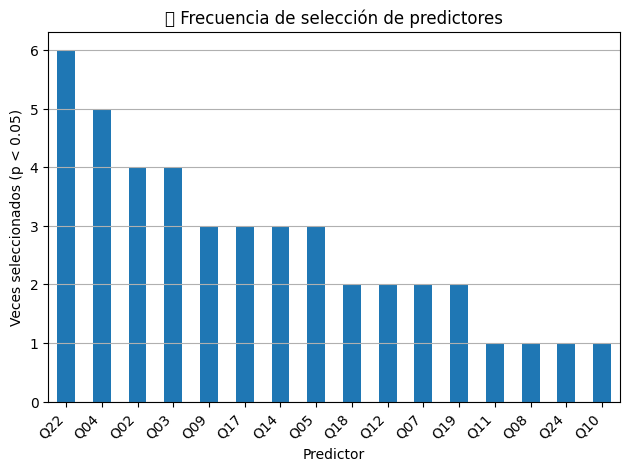

In [1]:
# ANALISIS 2
##########################
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Cargar datos
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: El archivo 'Dataset.Sunampe.Vaccine.xlsx' no fue encontrado.")
    exit()

variables = [col for col in df.columns if col.startswith("Q")]
resultados_excel = []
conteo_predictores = {}

def forward_selection(data, target, predictors, threshold_in=0.05):
    selected = []
    remaining = [p for p in predictors if p != target]
    best_aic = float('inf')
    resultados = []

    while remaining:
        aic_with_candidates = []
        for candidate in remaining:
            try:
                X = sm.add_constant(data[selected + [candidate]])
                y = data[target]
                model = sm.Logit(y, X).fit(disp=0)
                aic = model.aic
                pval = model.pvalues[candidate]
                aic_with_candidates.append((aic, candidate, pval))
            except:
                continue

        if not aic_with_candidates:
            break

        aic_with_candidates.sort()
        best_new_aic, best_candidate, best_pval = aic_with_candidates[0]

        if best_pval < threshold_in:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_aic = best_new_aic
            resultados.append((target, best_candidate, best_pval, best_new_aic))
            conteo_predictores[best_candidate] = conteo_predictores.get(best_candidate, 0) + 1
        else:
            break

    return resultados

# Aplicar forward selection para cada target
for target in variables:
    predictors = [col for col in variables if col != target]
    resultados = forward_selection(df, target, predictors)
    resultados_excel.extend(resultados)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados_excel, columns=["Target", "Predictor", "P-Value", "AIC"])

# Guardar en Excel
nombre_archivo = "resultados_forward_selection.xlsx"
df_resultados.to_excel(nombre_archivo, index=False)
print(f"✅ Resultados guardados en '{nombre_archivo}'")

# Graficar conteo de predictores seleccionados
conteo_df = pd.DataFrame.from_dict(conteo_predictores, orient='index', columns=['Frecuencia'])
conteo_df = conteo_df.sort_values("Frecuencia", ascending=False)

plt.figure(figsize=(10, 6))
conteo_df.plot(kind='bar', legend=False)
plt.title("📊 Frecuencia de selección de predictores")
plt.ylabel("Veces seleccionados (p < 0.05)")
plt.xlabel("Predictor")
plt.tight_layout()
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.savefig("grafico_predictores_frecuentes.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

✅ Resultados con AUC y Accuracy guardados en 'resultados_forward_selection_con_AUC_accuracy.xlsx'


<ipython-input-4-ee0ba9da3ec7>:101: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-ee0ba9da3ec7>:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_predictores_frecuentes.png")


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


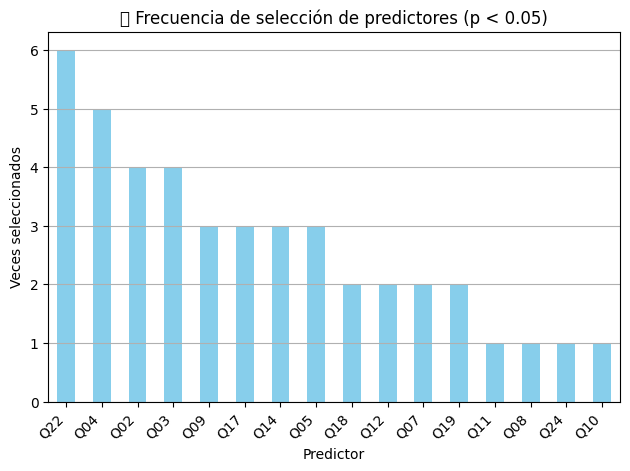

In [4]:
#MEJORANDO LO ANTERIOR con forward selection
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

# Cargar datos
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: El archivo 'Dataset.Sunampe.Vaccine.xlsx' no fue encontrado.")
    exit()

variables = [col for col in df.columns if col.startswith("Q")]
resultados_excel = []
conteo_predictores = {}

def forward_selection(data, target, predictors, threshold_in=0.05):
    selected = []
    remaining = [p for p in predictors if p != target]
    best_aic = float('inf')
    resultados = []

    while remaining:
        aic_with_candidates = []
        for candidate in remaining:
            try:
                X = sm.add_constant(data[selected + [candidate]])
                y = data[target]

                if len(y.unique()) < 2:
                    continue

                model = sm.Logit(y, X).fit(disp=0)
                aic = model.aic
                pval = model.pvalues[candidate]
                aic_with_candidates.append((aic, candidate, pval, model))
            except:
                continue

        if not aic_with_candidates:
            break

        aic_with_candidates.sort()
        best_new_aic, best_candidate, best_pval, best_model = aic_with_candidates[0]

        if best_pval < threshold_in:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_aic = best_new_aic
            y_pred = best_model.predict(sm.add_constant(data[selected]))
            y_class = (y_pred >= 0.5).astype(int)

            try:
                auc = roc_auc_score(data[target], y_pred)
                acc = accuracy_score(data[target], y_class)
            except:
                auc = float('nan')
                acc = float('nan')

            resultados.append({
                "Target": target,
                "Predictor": best_candidate,
                "P-Value": best_pval,
                "AIC": best_new_aic,
                "AUC": auc,
                "Accuracy": acc
            })

            conteo_predictores[best_candidate] = conteo_predictores.get(best_candidate, 0) + 1
        else:
            break

    return resultados

# Aplicar forward selection para cada target
for target in variables:
    predictors = [col for col in variables if col != target]
    resultados = forward_selection(df, target, predictors)
    resultados_excel.extend(resultados)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados_excel)

# Guardar en Excel
archivo_excel = "resultados_forward_selection_con_AUC_accuracy.xlsx"
df_resultados.to_excel(archivo_excel, index=False)
print(f"✅ Resultados con AUC y Accuracy guardados en '{archivo_excel}'")

# Graficar frecuencia de selección de predictores
conteo_df = pd.DataFrame.from_dict(conteo_predictores, orient='index', columns=['Frecuencia'])
conteo_df = conteo_df.sort_values("Frecuencia", ascending=False)

plt.figure(figsize=(10, 6))
conteo_df.plot(kind='bar', legend=False, color='skyblue')
plt.title("📊 Frecuencia de selección de predictores (p < 0.05)")
plt.ylabel("Veces seleccionados")
plt.xlabel("Predictor")
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.savefig("grafico_predictores_frecuentes.png")
plt.show()



In [10]:
print(target)
print(predictors)

Q25
['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24']


In [11]:
#import pandas as pd

# Nombre del archivo Excel guardado previamente
#archivo_excel = "resultados_forward_selection_con_AUC_accuracy.xlsx"

# Cargar el DataFrame desde el archivo Excel
#df_resultados_cargado = pd.read_excel(archivo_excel)

# Verificar las primeras filas para confirmar que se cargó correctamente
#print(df_resultados_cargado.head())

# Filtrar resultados para los targets Q02, Q03, Q04 y Q05
targets_interes = ['Q22', 'Q02', 'Q03', 'Q04', 'Q05', 'Q14', 'Q17']
mejores_modelos = df_resultados[df_resultados['Target'].isin(targets_interes)]

# Mostrar resultados ordenados por Target y AIC ascendente
mejores_modelos_ordenados = mejores_modelos.sort_values(by=['Target', 'AIC'])
print("\n🔍 Mejores modelos para Q22 Q02 Q03 Q04 Q05 Q14  y Q17:")
print(mejores_modelos_ordenados[['Target', 'Predictor', 'P-Value', 'AIC', 'AUC', 'Accuracy']])

# Guardar estos modelos en una hoja separada del Excel
with pd.ExcelWriter(archivo_excel, engine='openpyxl', mode='a') as writer:
    mejores_modelos_ordenados.to_excel(writer, sheet_name='Q02-Q05_models', index=False)
print(f"✅ Resultados de Q02–Q05 también guardados en la hoja 'Q02-Q05_models' de '{archivo_excel}'")



🔍 Mejores modelos para Q22 Q02 Q03 Q04 Q05 Q14  y Q17:
   Target Predictor   P-Value         AIC       AUC  Accuracy
3     Q02       Q22  0.022866  124.290718  0.842676  0.853659
2     Q02       Q09  0.010418  127.897483  0.819143  0.861789
1     Q02       Q03  0.000053  134.004345  0.830777  0.837398
0     Q02       Q05  0.000004  150.672217  0.715759  0.715447
6     Q03       Q18  0.011683  125.806103  0.812821  0.764228
5     Q03       Q12  0.002977  131.934362  0.781339  0.723577
4     Q03       Q02  0.000007  142.014842  0.722222  0.707317
11    Q04       Q09  0.021455  124.403869  0.854466  0.796748
10    Q04       Q22  0.020412  128.347775  0.845295  0.804878
9     Q04       Q14  0.031481  132.079049  0.830409  0.796748
8     Q04       Q05  0.000543  135.950778  0.806885  0.788618
7     Q04       Q17  0.000001  146.432326  0.729266  0.723577
14    Q05       Q22  0.028189  139.055772  0.789341  0.756098
13    Q05       Q04  0.001922  142.280473  0.777379  0.821138
12    Q05     

ValueError: Sheet 'Q02-Q05_models' already exists and if_sheet_exists is set to 'error'.

<ipython-input-12-7a6174c8f078>:11: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-7a6174c8f078>:12: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig("AUC_Q02_Q05.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


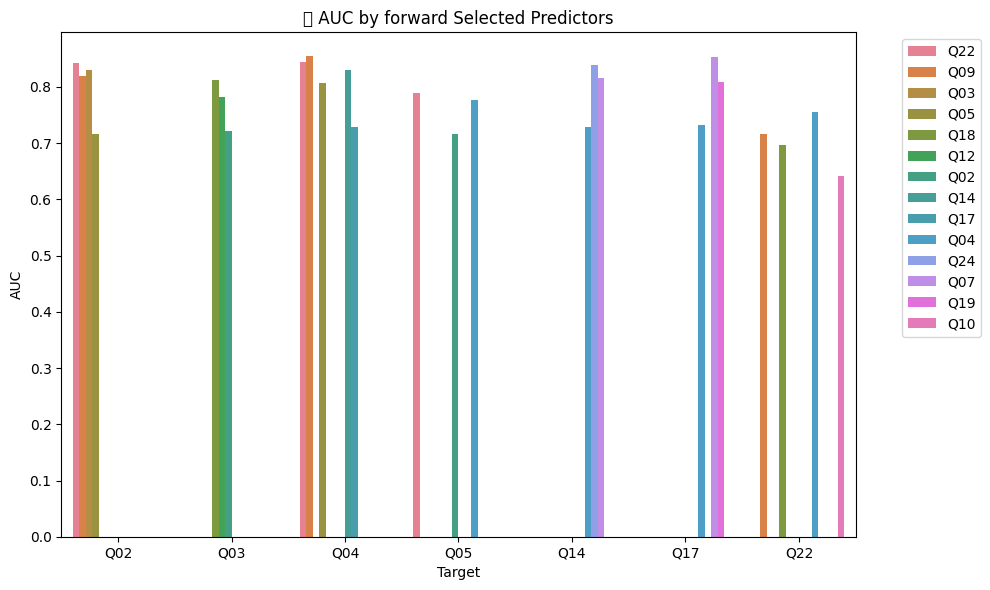

In [12]:
import seaborn as sns

# Gráfico de barras agrupado
plt.figure(figsize=(10, 6))
sns.barplot(data=mejores_modelos_ordenados, x='Target', y='AUC', hue='Predictor', dodge=True)
plt.title("🎯 AUC by forward Selected Predictors")
plt.ylabel("AUC")
plt.xlabel("Target")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("AUC_Q02_Q05.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

✅ Resultados guardados en 'resultados_forward_selection_Q02_Q03_Q04_Q05.xlsx'


<ipython-input-1-cd62078c9bf3>:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-cd62078c9bf3>:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_predictores_frecuentes_Q02_Q03_Q04_Q05.png")


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


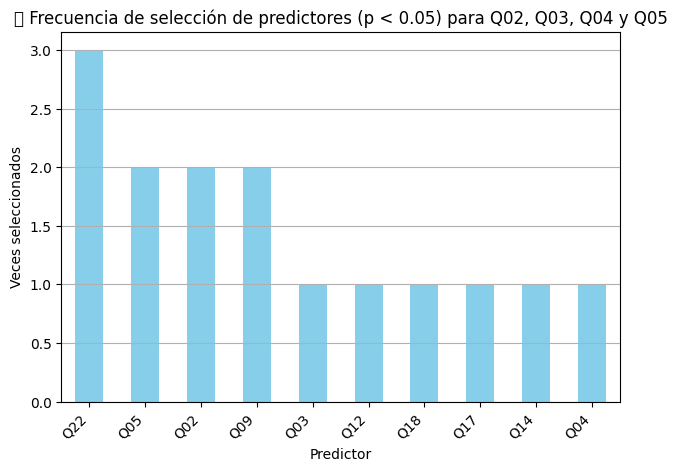

In [1]:
# ... dibujando mejores ROC
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

# Cargar datos
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: El archivo 'Dataset.Sunampe.Vaccine.xlsx' no fue encontrado.")
    exit()

# Definir variables y targets específicos
variables = [col for col in df.columns if col.startswith("Q")]
targets_mejores = ['Q02', 'Q03', 'Q04', 'Q05']

resultados_excel = []
conteo_predictores = {}

def forward_selection(data, target, predictors, threshold_in=0.05):
    selected = []
    remaining = [p for p in predictors if p != target]
    best_aic = float('inf')
    resultados = []

    while remaining:
        aic_with_candidates = []
        for candidate in remaining:
            try:
                X = sm.add_constant(data[selected + [candidate]])
                y = data[target]

                if len(y.unique()) < 2:
                    continue

                model = sm.Logit(y, X).fit(disp=0)
                aic = model.aic
                pval = model.pvalues[candidate]
                aic_with_candidates.append((aic, candidate, pval, model))
            except Exception as e:
                # Puedes descomentar para debuggear: print(f"Error con {candidate}: {e}")
                continue

        if not aic_with_candidates:
            break

        aic_with_candidates.sort()
        best_new_aic, best_candidate, best_pval, best_model = aic_with_candidates[0]

        if best_pval < threshold_in:
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_aic = best_new_aic
            y_pred = best_model.predict(sm.add_constant(data[selected]))
            y_class = (y_pred >= 0.5).astype(int)

            try:
                auc = roc_auc_score(data[target], y_pred)
                acc = accuracy_score(data[target], y_class)
            except:
                auc = float('nan')
                acc = float('nan')

            resultados.append({
                "Target": target,
                "Predictor": best_candidate,
                "P-Value": best_pval,
                "AIC": best_new_aic,
                "AUC": auc,
                "Accuracy": acc
            })

            conteo_predictores[best_candidate] = conteo_predictores.get(best_candidate, 0) + 1
        else:
            break

    return resultados

# Aplicar forward selection solo para targets Q02, Q03, Q04 y Q05
for target in targets_mejores:
    predictors = [col for col in variables if col != target]
    resultados = forward_selection(df, target, predictors)
    resultados_excel.extend(resultados)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados_excel)

# Guardar resultados en Excel
archivo_excel = "resultados_forward_selection_Q02_Q03_Q04_Q05.xlsx"
df_resultados.to_excel(archivo_excel, index=False)
print(f"✅ Resultados guardados en '{archivo_excel}'")

# Graficar frecuencia de selección de predictores en este subconjunto
conteo_df = pd.DataFrame.from_dict(conteo_predictores, orient='index', columns=['Frecuencia'])
conteo_df = conteo_df.sort_values("Frecuencia", ascending=False)

plt.figure(figsize=(10, 6))
conteo_df.plot(kind='bar', legend=False, color='skyblue')
plt.title("📊 Frecuencia de selección de predictores (p < 0.05) para Q02, Q03, Q04 y Q05")
plt.ylabel("Veces seleccionados")
plt.xlabel("Predictor")
plt.grid(axis='y')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.savefig("grafico_predictores_frecuentes_Q02_Q03_Q04_Q05.png")
plt.show()
